In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import phate

from scipy import sparse

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

from External.ICT.calculate_ICT import calculate_ICT, calculate_sub_ICTs
from External.clustering import centers, k_means_pp
from External.generation import create_graph
from External.plotting import plot_points, plot_graph, no_intersections
from External.create_k_nearest import patch_together

plt.style.use('standard.mplstyle')

<ipython-input-5-6245be75c264>:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1


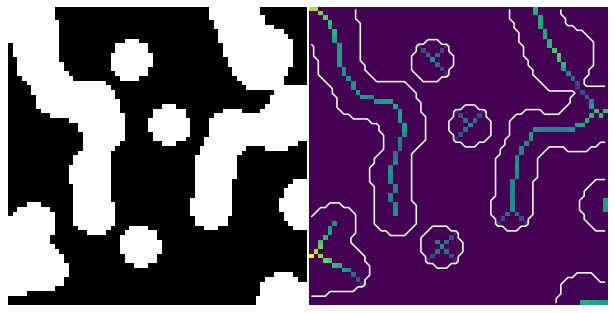

In [5]:
import numpy as np
from scipy import ndimage
from skimage.morphology import medial_axis
import matplotlib.pyplot as plt


def microstructure(l=256):
    """
    Synthetic binary data: binary microstructure with blobs.

    Parameters
    ----------

    l: int, optional
        linear size of the returned image

    """
    n = 5
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l/2)**2 + (y - l/2)**2 < (l/2)**2
    mask = np.zeros((l, l))
    generator = np.random.RandomState(1)
    points = l * generator.rand(2, n**2)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l/(4.*n))
    return mask > mask.mean()

data = microstructure(l=64)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(data, return_distance=True)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, interpolation='nearest')
ax2.contour(data, [0.5], colors='w')
ax2.axis('off')

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.show()

In [6]:
# Hyperparameters
mode = "K_Nearest"
metric = "euclidean"
dataset = "non_convex"
ICT_algorithm = "cluster_all"


# image loading
n = number_of_nodes = 1000
Random = False
image_name = "image"

In [7]:
def load_image(filename):
    a=plt.imread(filename+'.png')
    rgb_weights = [0.2989, 0.5870, 0.1140]
    
    grayscale_image = np.dot(a[...,:3], rgb_weights)>0
    
    return grayscale_image
    
    
def sample_points_from_image(n,img,Random=True):
    if not Random:
        random.seed(42)
    non_zero = np.where(img!=0)
    # non_zero=np.vstack((non_zero[0],non_zero[1])).T
    
    
    idx = random.sample(range(len(non_zero[0])),n)
    
    x_coord = non_zero[0][idx]
    y_coord = non_zero[1][idx]
    return x_coord,y_coord

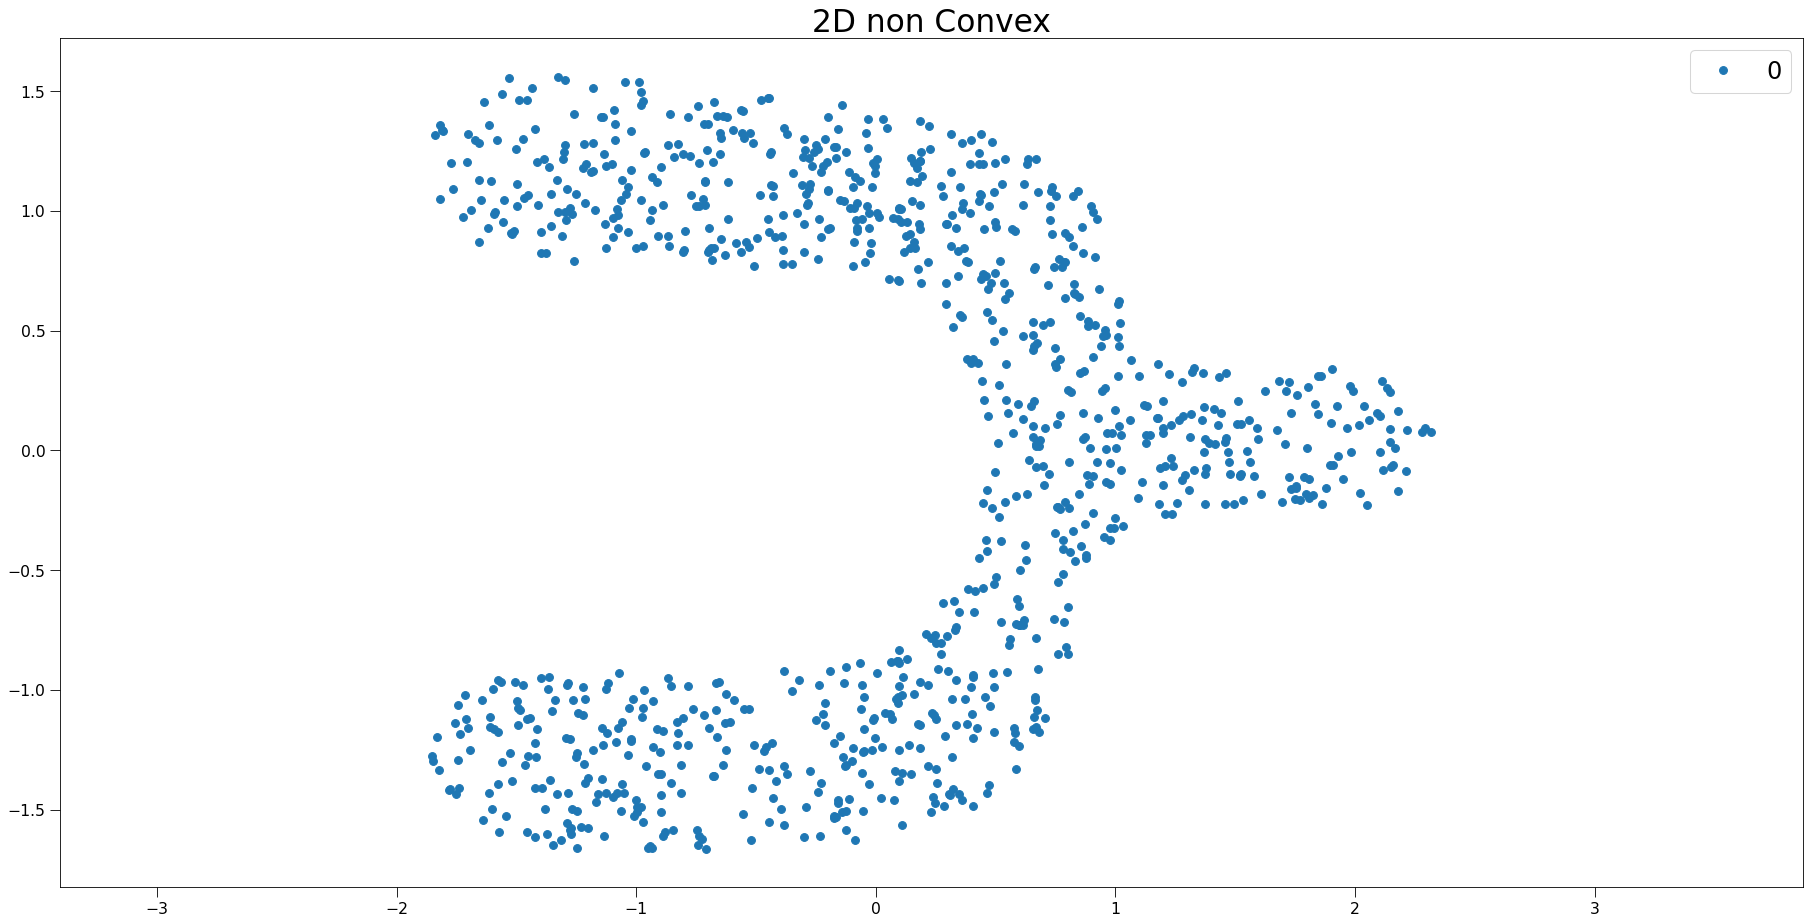

In [8]:
# Compute the position array
img = load_image(image_name)
position = np.array(sample_points_from_image(n,img,Random)).T
position = StandardScaler().fit_transform(position)

fig, ax = plt.subplots(1)
plot_points(position, f"2D non Convex", ax)

In [9]:
d = pairwise_distances(position)
d[d==0] = np.inf
min_distance = np.min(d, axis=0)
avg_distance = np.mean(min_distance)

dims = position.shape[-1]
radius = 3 * avg_distance
a = radius * (2 / np.sqrt(dims))*0.9

In [10]:
borders = [[] for _ in range(dims)]

for i in range(dims):
    p = position[...,i]
    r = np.min(p)
    s = np.max(p)
    borders[i] = [r, s, ((s-r) // a) + 1 , a]
    borders[i][0] -= 1/2 * borders[i][3]
    borders[i][1] += 3/2 * borders[i][3]
    borders[i][2] += 2
    
borders = np.array(borders) 

centers = []

for x in borders[0][0] + (np.arange(borders[0][2])) * borders[1][3]:
    for y in borders[1][0] + (np.arange(borders[1][2])) * borders[1][3]:
        centers.append([x,y])
        
centers = np.array(centers)

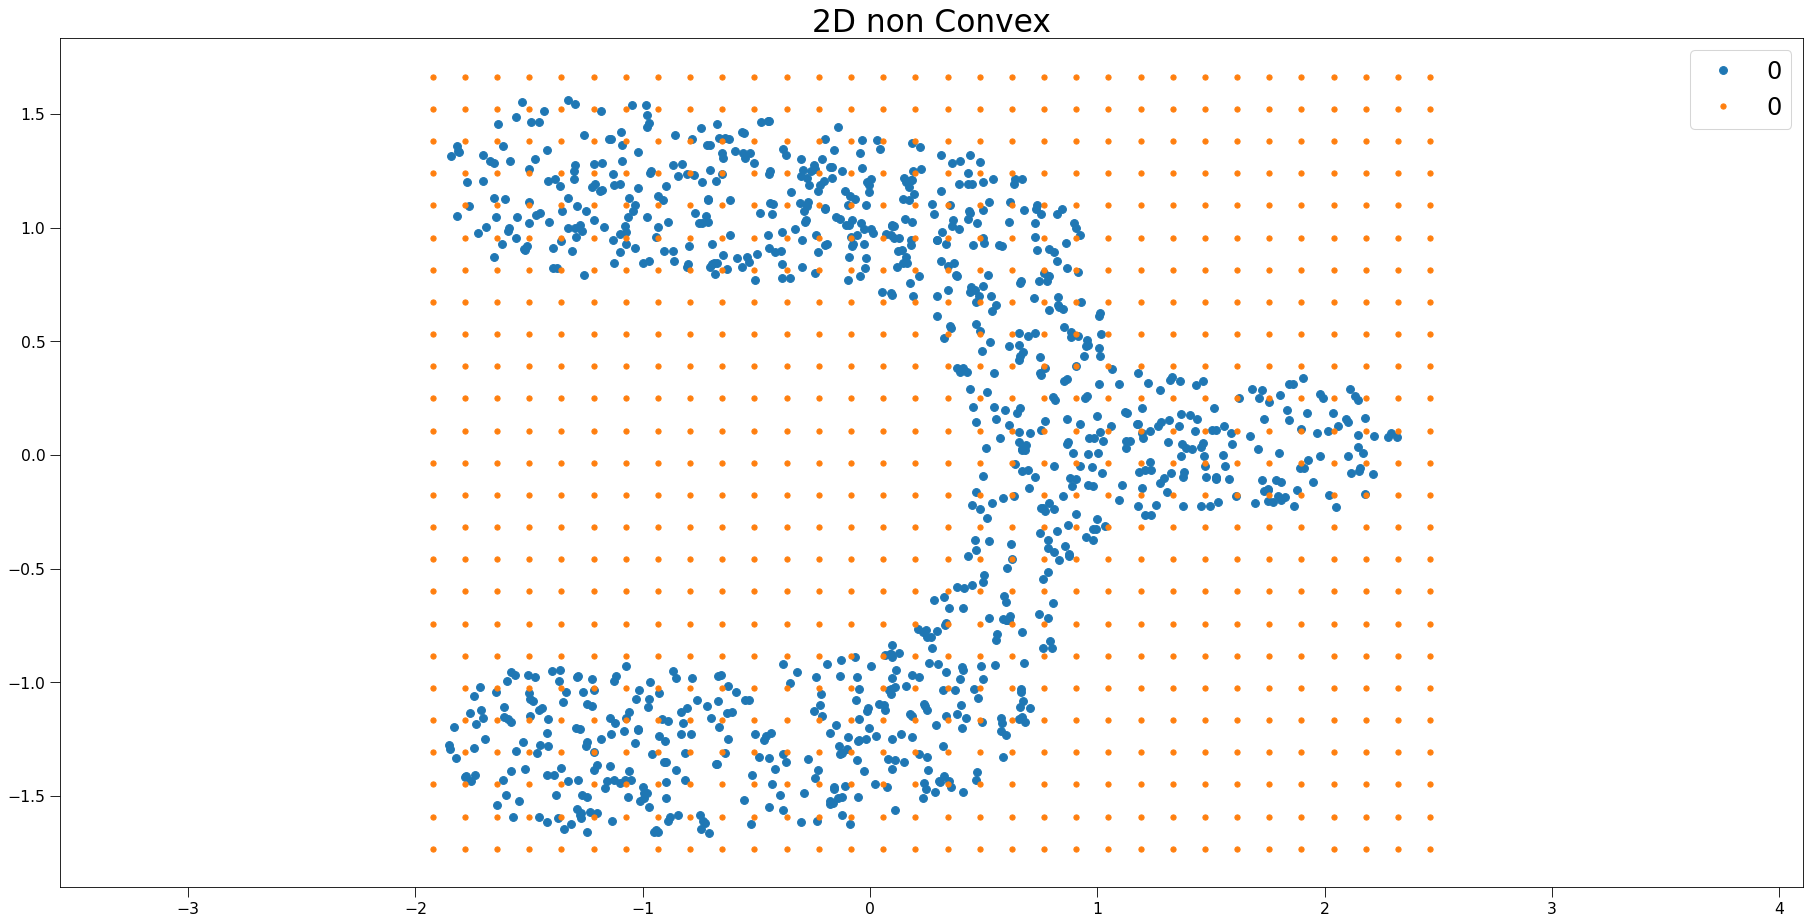

In [11]:
fig, ax = plt.subplots(1)
plot_points(position, f"2D non Convex", ax)
plot_points(centers, f"2D non Convex", ax, node_size=10)

In [12]:
# Horseshoe circles
circles = np.zeros(shape=borders.T[2].astype(int))
distances = pairwise_distances(centers.reshape(-1,2), position)
distances[distances<radius] = 0
circles1 = (len(position) - np.count_nonzero(distances, axis=1)).reshape(circles.shape)


# Horseshoe gaus
g = np.zeros(shape=borders.T[2].astype(int))
distances = pairwise_distances(centers.reshape(-1,2), position)
g1 = np.sum(np.exp(-distances**2 * 200), axis=1).reshape(g.shape)


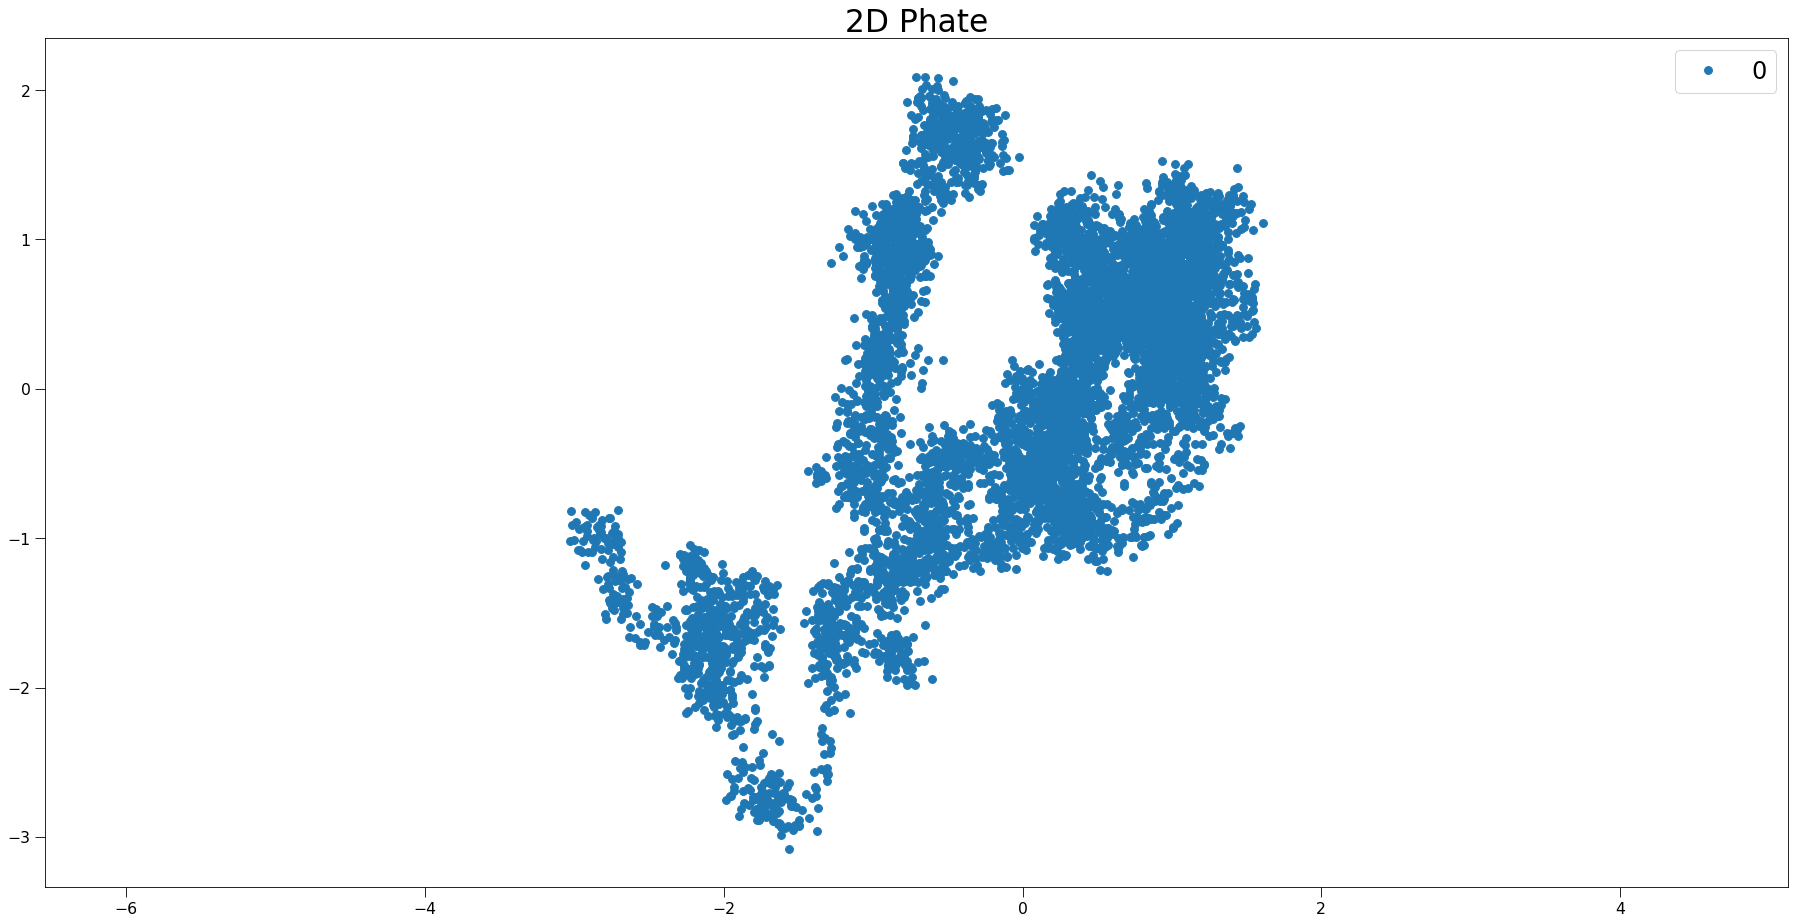

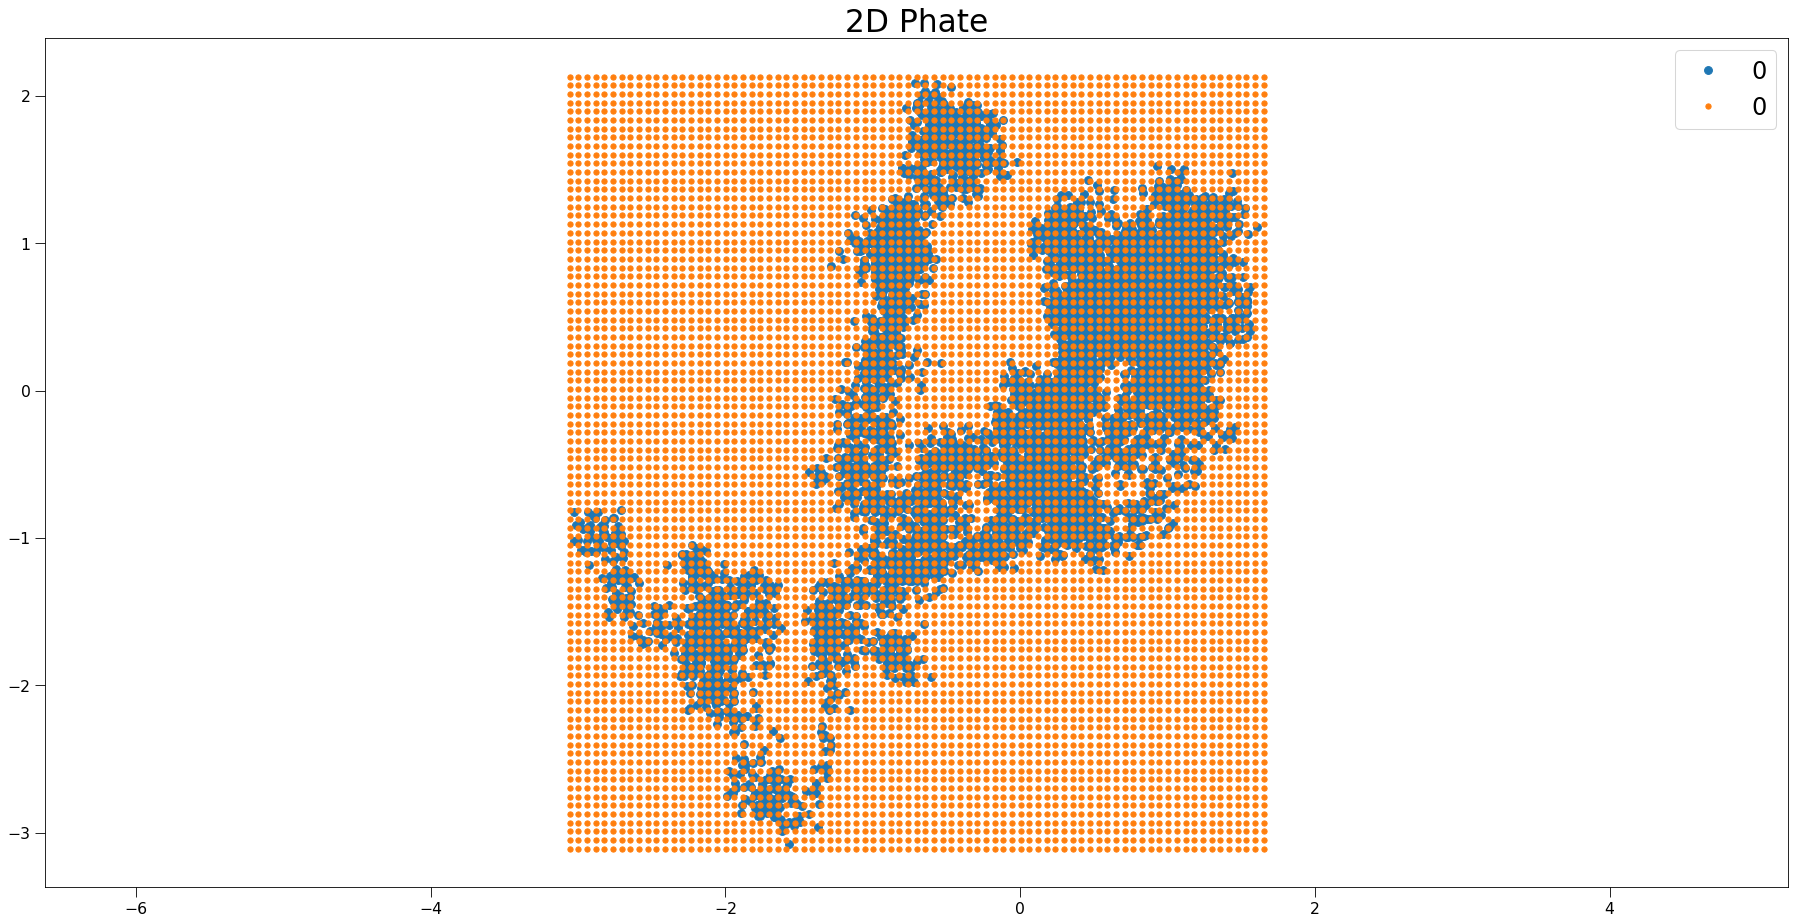

In [13]:
# 2D Phate
img = load_image(image_name)
position = np.array(sample_points_from_image(n,img,Random)).T
position = StandardScaler().fit_transform(position)




position, labels = phate.tree.gen_dla(n_dim=2, n_branch=3,
                                            branch_length=2500, rand_multiplier=2, seed=37, sigma=1)
position = StandardScaler().fit_transform(position)
number_of_nodes = len(position)


fig, ax = plt.subplots(1)
plot_points(position, f"2D Phate", ax)

d = pairwise_distances(position)
d[d==0] = np.inf
min_distance = np.min(d, axis=0)
avg_distance = np.mean(min_distance)

dims = position.shape[-1]
radius = 3 * avg_distance
a = radius * (2 / np.sqrt(dims))*0.9

borders = [[] for _ in range(dims)]

for i in range(dims):
    p = position[...,i]
    r = np.min(p)
    s = np.max(p)
    borders[i] = [r, s, ((s-r) // a) + 1 , a]
    borders[i][0] -= 1/2 * borders[i][3]
    borders[i][1] += 3/2 * borders[i][3]
    borders[i][2] += 2
    
borders = np.array(borders) 

centers = []

for x in borders[0][0] + (np.arange(borders[0][2])) * borders[1][3]:
    for y in borders[1][0] + (np.arange(borders[1][2])) * borders[1][3]:
        centers.append([x,y])
        
centers = np.array(centers)

fig, ax = plt.subplots(1)
plot_points(position, f"2D Phate", ax)
plot_points(centers, f"2D Phate", ax, node_size=10)

In [14]:
circles = np.zeros(shape=borders.T[2].astype(int))
distances = pairwise_distances(centers.reshape(-1,2), position)
distances[distances<radius] = 0
circles2 = (len(position) - np.count_nonzero(distances, axis=1)).reshape(circles.shape)
circles2 = circles2 ** 0.65

g = np.zeros(shape=borders.T[2].astype(int))
distances = pairwise_distances(centers.reshape(-1,2), position)
g2 = np.sum(np.exp(-distances**2 * 50), axis=1).reshape(g.shape)
g2[g2 < 0.1] = 0
g2 = g2 ** 0.65

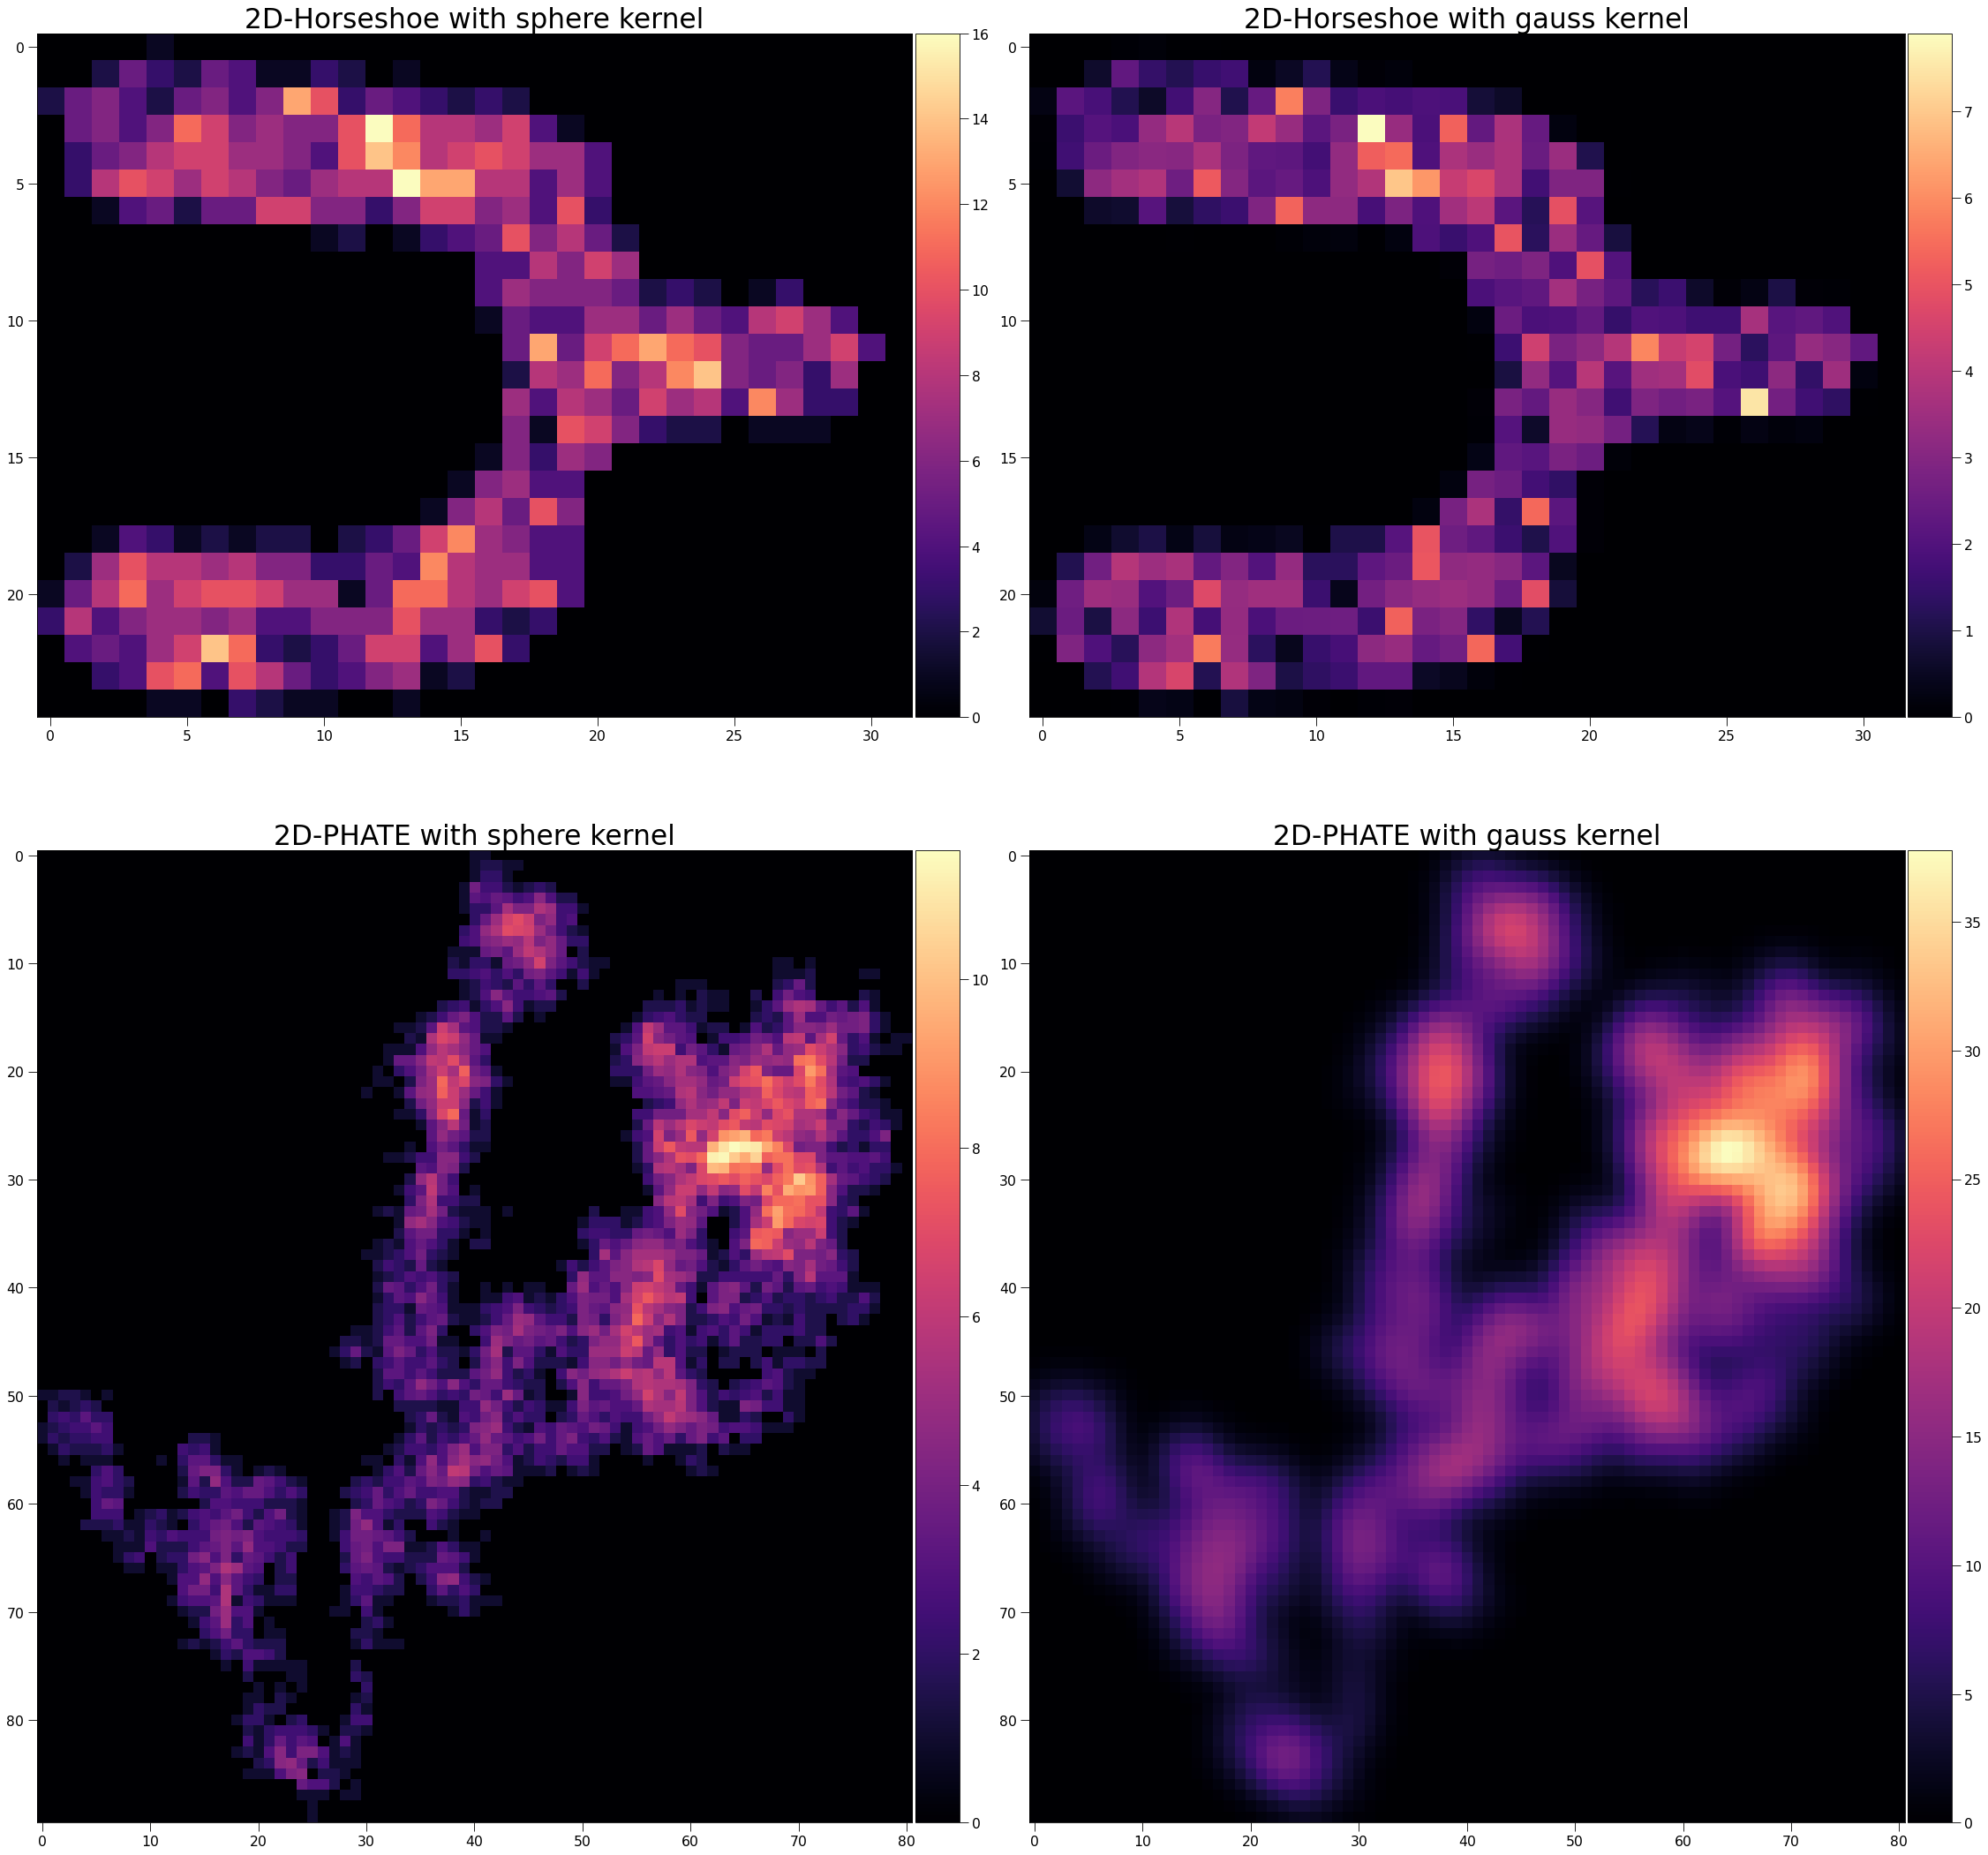

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(2,2, figsize=(30,30))


im1 = ax[0,0].imshow(circles1.T[::-1], cmap="magma")
ax[0,0].set_title("2D-Horseshoe with sphere kernel")
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[0,1].imshow(g1.T[::-1], cmap="magma")
ax[0,1].set_title("2D-Horseshoe with gauss kernel")
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


im3 = ax[1,0].imshow(circles2.T[::-1], cmap="magma")
ax[1,0].set_title("2D-PHATE with sphere kernel")
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

im4 = ax[1,1].imshow(g2.T[::-1], cmap="magma")
ax[1,1].set_title("2D-PHATE with gauss kernel")
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical')


plt.tight_layout()
plt.savefig("./Output/Erosion.png")
plt.show()

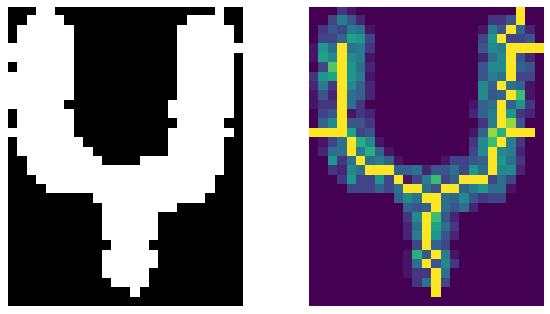

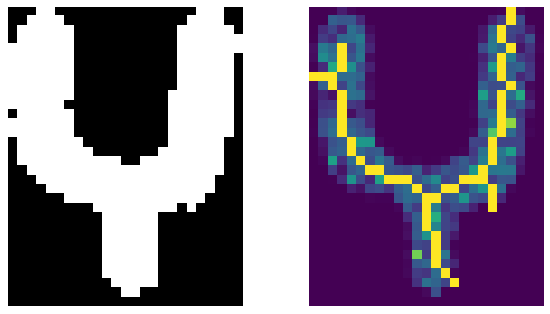

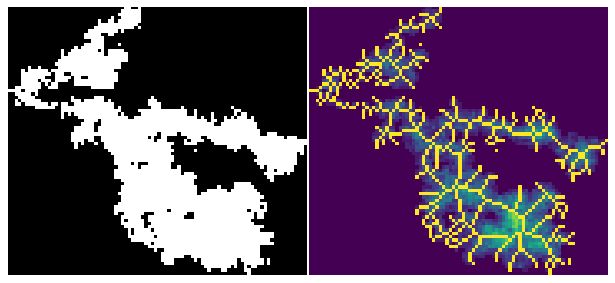

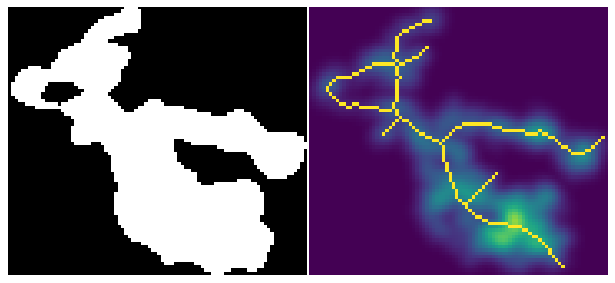

In [16]:
from copy import deepcopy
for i, image in enumerate([circles1, g1, circles2, g2]):
    data = deepcopy(image)
    x = 0
    if i==1:
        x = 0.05
    if i==3:
        x = 3.5
    data[data<x] = 0
    data[data>x] = 1
    # Compute the medial axis (skeleton) and the distance transform
    skel, distance = medial_axis(data, return_distance=True)

    # Distance to the background for pixels of the skeleton
    dist_on_skel = distance * skel

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
    ax1.axis('off')
    dist_on_skel[dist_on_skel>0] = 20
    new_image = deepcopy(image)
    new_image[skel>0] = skel[skel>0]*1.2*np.max(image)
    ax2.imshow(new_image, interpolation='nearest')
    # ax2.contour(data, [0.5], colors='w')
    ax2.axis('off')

    fig.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
    plt.show()
    
    image[image>-1] = new_image[image>-1]

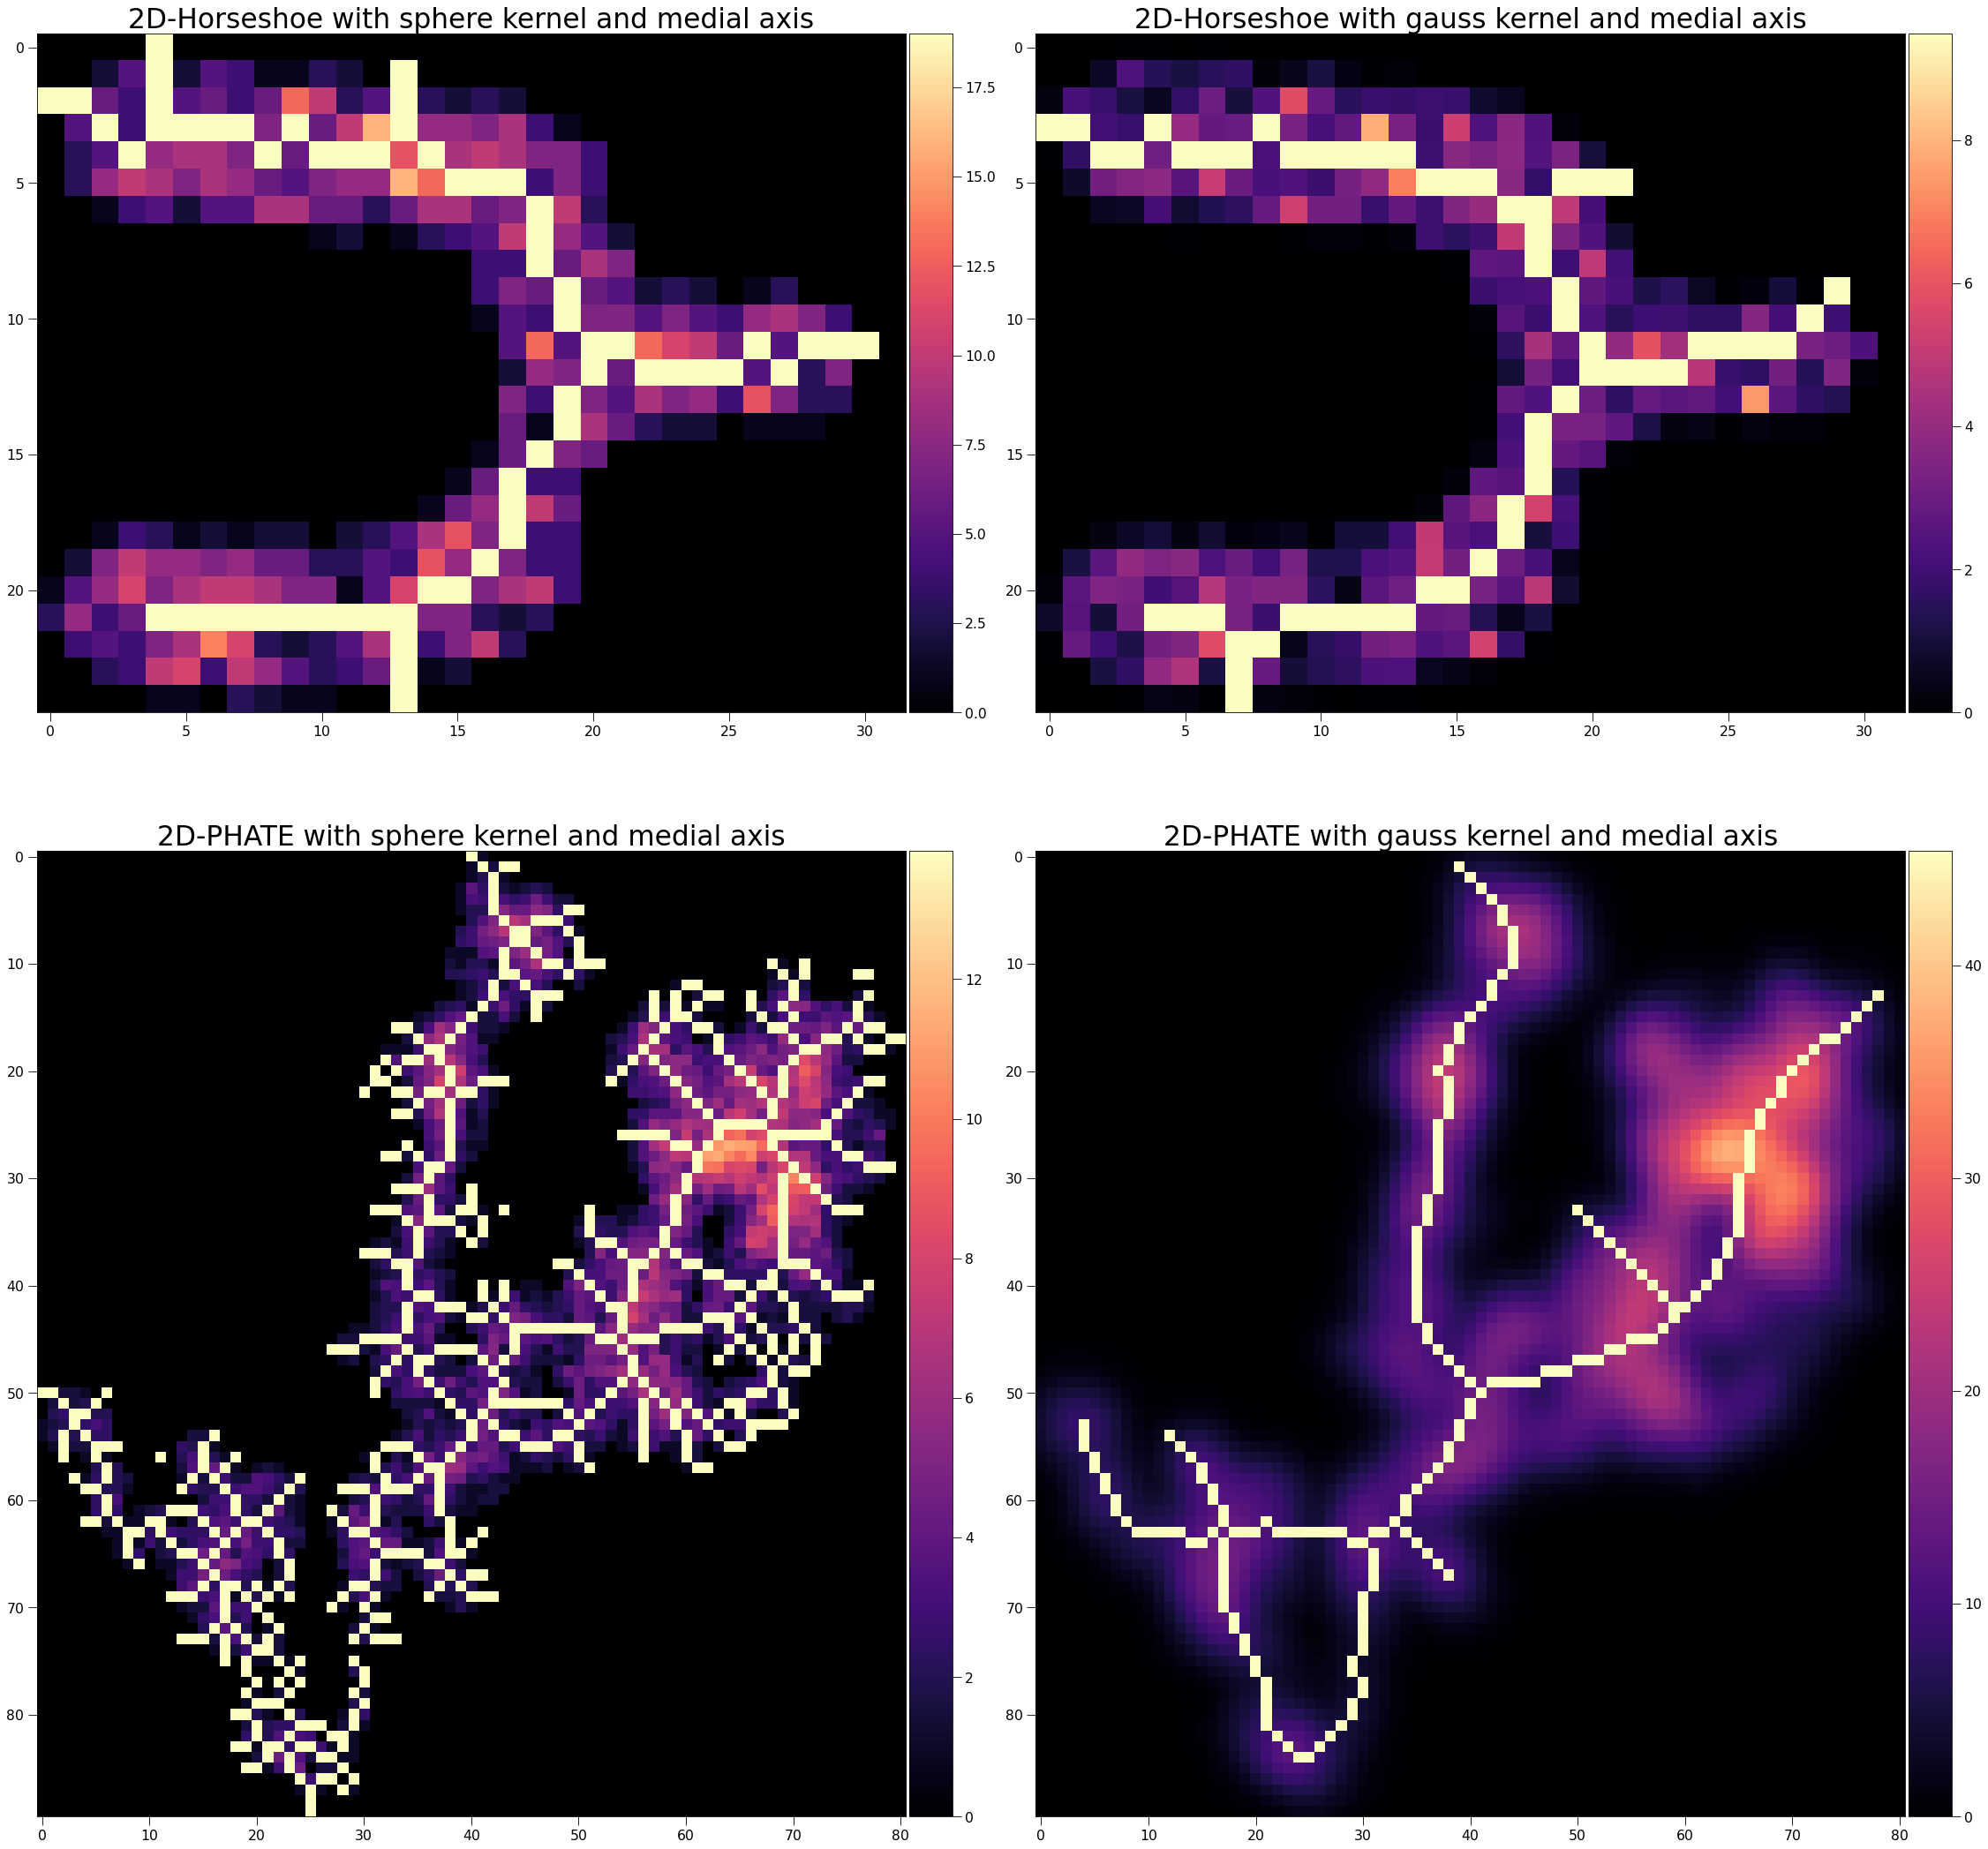

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(2,2, figsize=(30,30))


im1 = ax[0,0].imshow(circles1.T[::-1], cmap="magma")
ax[0,0].set_title("2D-Horseshoe with sphere kernel and medial axis")
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[0,1].imshow(g1.T[::-1], cmap="magma")
ax[0,1].set_title("2D-Horseshoe with gauss kernel and medial axis")
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


im3 = ax[1,0].imshow(circles2.T[::-1], cmap="magma")
ax[1,0].set_title("2D-PHATE with sphere kernel and medial axis")
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

im4 = ax[1,1].imshow(g2.T[::-1], cmap="magma")
ax[1,1].set_title("2D-PHATE with gauss kernel and medial axis")
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical')


plt.tight_layout()
plt.savefig("./Output/Erosion+axis.png")
plt.show()